In [69]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn import datasets
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import cluster
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [70]:
def make_confusion_matrix(cf, train_accuracy, test_accuracy, group_names=None, categories='auto', count=True, percent=True, cbar=True, xyticks=True, xyplotlabels=True, sum_stats=True, figsize=None, cmap='Blues', title=None):
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    if sum_stats:

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nTrain_Accuracy={:0.3f}\nTest_Accuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                train_accuracy,test_accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False

    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [71]:
#import fake news dataset
data_set = pd.read_csv("news.csv")
data_set = data_set.drop(columns={"Unnamed: 0", "title"})
data_set

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL
...,...,...
6330,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [72]:
#Preprocessing the text data
#Step 1: Drop all the duplicate rows
data_set.drop_duplicates(subset='text', inplace=True)
data_set = data_set.reset_index(drop=True)

#Step 2: Converting each word to lower case
data_set.text = data_set.text.str.lower()

#Step 3: Remove all the punctuations and other characters
data_set.text = data_set.text.str.replace('[^\w\s]',' ')

#Step 4: Remove all the numbers
data_set.text = data_set.text.str.replace('[^A-Za-z]',' ')

#step 5: Convert double space to single space
data_set.text = data_set.text.str.replace('  ',' ')

#Step 6: Removing stop words and Lemmetizing the text
stop_words = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()
for i in range(data_set.text.size):
    data_set.text[i] = nltk.word_tokenize(data_set.text[i])
    filtered_tokens = [lemmatizer.lemmatize(token) for token in data_set.text[i] if token not in stop_words]
    data_set.text[i] = ' '.join(filtered_tokens)


data_set

,text,label
0,daniel greenfield shillman journalism fellow f...,FAKE
1,google pinterest digg linkedin reddit stumbleu...,FAKE
2,u secretary state john f kerry said monday sto...,REAL
3,kaydee king kaydeeking november lesson tonight...,FAKE
4,primary day new york front runner hillary clin...,REAL
...,...,...
6055,state department told republican national comm...,REAL
6056,p pb stand plutocratic pentagon posted oct wik...,FAKE
6057,anti trump protester tool oligarchy reform alw...,FAKE
6058,addis ababa ethiopia president obama convened ...,REAL


In [73]:
#Binarizing lables
data_set.label = data_set.label.map({"REAL":1, "FAKE":0})
data_set

,text,label
0,daniel greenfield shillman journalism fellow f...,0
1,google pinterest digg linkedin reddit stumbleu...,0
2,u secretary state john f kerry said monday sto...,1
3,kaydee king kaydeeking november lesson tonight...,0
4,primary day new york front runner hillary clin...,1
...,...,...
6055,state department told republican national comm...,1
6056,p pb stand plutocratic pentagon posted oct wik...,0
6057,anti trump protester tool oligarchy reform alw...,0
6058,addis ababa ethiopia president obama convened ...,1


In [75]:
mask_on = data_set.label == 1
df_real_text = data_set[mask_on]['text']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(max_features=5000, stop_words = 'english', ngram_range=(1,3))

# Fit and transform the vectorizer on our corpus
real_cvec = cv1.fit_transform(df_real_text)

# Convert real_cvec into a DataFrame
real_cvec_df = pd.DataFrame(real_cvec.toarray(), columns=cv1.get_feature_names())

In [76]:
real_cvec_df

,abandon,abandoned,abc,abc news,abdeslam,abdullah,abedin,ability,able,abortion,...,york time,young,young people,young voter,young woman,younger,youth,zarif,zero,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
mask_no = data_set.label == 0
df_fake_text = data_set[mask_no]['text']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(max_features=5000, stop_words = 'english', ngram_range=(1,3))

# Fit and transform the vectorizer on our corpus
fake_cvec = cv1.fit_transform(df_fake_text)

# Convert fake_cvec into a DataFrame
fake_cvec_df = pd.DataFrame(fake_cvec.toarray(), columns=cv1.get_feature_names())
fake_cvec_df

,abandon,abandoned,abc,abedin,ability,able,aborigine,abortion,abroad,absolute,...,yugoslavia,zealand,zero,zero hedge,zika,zika virus,zionist,zone,zone syria,zulu
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3067,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3068,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3069,0,1,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


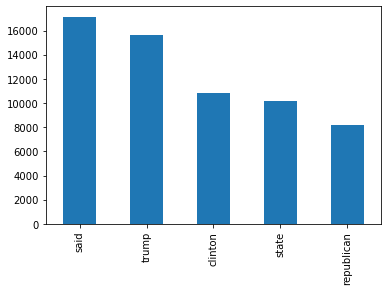

In [81]:
# Set up variables to contain top 5 most used words in Real
real_wc = real_cvec_df.sum(axis = 0)
real_top_5 = real_wc.sort_values(ascending=False).head(5)
real_top_5
# Call function
real_top_5.plot.bar()
plt.show()

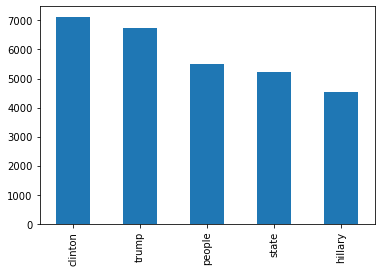

In [82]:
fake_wc = fake_cvec_df.sum(axis = 0)
fake_top_5 = fake_wc.sort_values(ascending=False).head(5)
fake_top_5
# Call function
fake_top_5.plot.bar()
plt.show()

In [83]:
# Baseline score
data_set.label.value_counts(normalize=False)
data_set.label.value_counts(normalize=True)*100

0    50.676568
1    49.323432
Name: label, dtype: float64

In [84]:
cv = CountVectorizer(max_features = 5000, ngram_range=(1,3))

# Fit and transform the vectorizer on our corpus
count_vector = cv.fit_transform(data_set.text)

# Convert convert count_vector into a DataFrame
cvec_df = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names())
cvec_df

,abandon,abandoned,abc,abc news,abdullah,abedin,ability,able,abortion,abroad,...,york time,young,young people,younger,youth,youtube,zero,zika,zionist,zone
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6056,0,1,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
6057,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6058,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
X = cvec_df
Y = data_set.label
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, train_size=0.8)

[[565  81]
 [ 82 484]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       646
           1       0.86      0.86      0.86       566

    accuracy                           0.87      1212
   macro avg       0.86      0.86      0.86      1212
weighted avg       0.87      0.87      0.87      1212

Test : 0.8655115511551155
train:  0.884075907590759


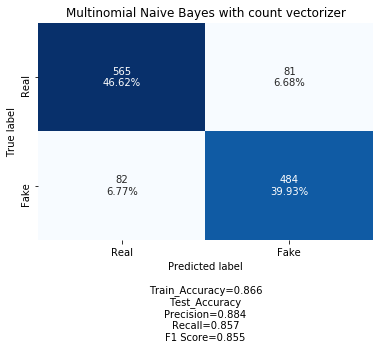

In [66]:
NB = MultinomialNB(alpha=0.36)
model_NB = NB.fit(x_train, y_train)
predicted_NB_test=model_NB.predict(x_test)
predicted_NB_train=model_NB.predict(x_train)
con_matrix_NB = metrics.confusion_matrix(y_test, predicted_NB_test)
report_NB = metrics.classification_report(y_test, predicted_NB_test)
accuracy_test = metrics.accuracy_score(y_test, predicted_NB_test)
accuracy_train = metrics.accuracy_score(y_train, predicted_NB_train)
print(con_matrix_NB)
print(report_NB)
print("Test :",accuracy_test)
print("train: ",accuracy_train)
make_confusion_matrix(con_matrix_NB, accuracy_train, accuracy_test, categories=["Real", "Fake"], cbar=False, title="Multinomial Naive Bayes with count vectorizer")

[[604  42]
 [ 61 505]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       646
           1       0.92      0.89      0.91       566

    accuracy                           0.92      1212
   macro avg       0.92      0.91      0.91      1212
weighted avg       0.92      0.92      0.91      1212

Test:  0.915016501650165
Train:  0.884075907590759


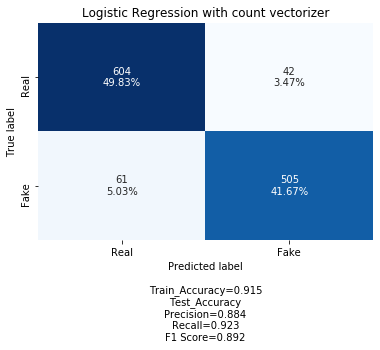

In [63]:
lr=linear_model.LogisticRegression(solver='liblinear', C=0.01)
model_lr = lr.fit(x_train, y_train)
predicted_lr_test = model_lr.predict(x_test)
predicted_lr_train = model_lr.predict(x_train)
con_matrix_lr = metrics.confusion_matrix(y_test, predicted_lr_test)
report_lr = metrics.classification_report(y_test, predicted_lr_test)
accuracy_test = metrics.accuracy_score(y_test, predicted_lr_test)
acuracy_train = metrics.accuracy_score(y_train, predicted_lr_train)
print(con_matrix_lr)
print(report_lr)
print("Test: ",accuracy_test)
print("Train: ",accuracy_train)
make_confusion_matrix(con_matrix_lr, accuracy_train, accuracy_test, categories=["Real", "Fake"], cbar=False, title="Logistic Regression with count vectorizer")

[[526  66]
 [ 73 547]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       620
           1       0.94      0.86      0.90       592

    accuracy                           0.90      1212
   macro avg       0.91      0.90      0.90      1212
weighted avg       0.91      0.90      0.90      1212

Test:  0.8853135313531353
Train:  0.9001650165016502


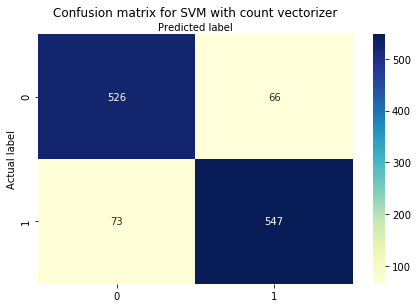

In [38]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
model_svm = SVM.fit(x_train, y_train)
predicted_svm_test = model_svm.predict(x_test)
predicted_svm_train = model_svm.predict(x_train)
con_matrix_svm = metrics.confusion_matrix(y_test, predicted_svm_test)
report_svm = metrics.classification_report(y_test, predicted_svm_test)
accuracy_test = metrics.accuracy_score(y_test, predicted_svm_test)
acuracy_train = metrics.accuracy_score(y_train, predicted_svm_train)
print(con_matrix_svm)
print(report_lr)
print("Test: ",accuracy_test)
print("Train: ",accuracy_train)
make_confusion_matrix(con_matrix_svm, accuracy_train, accuracy_test, categories=["Real", "Fake"], cbar=False, title="SVM with count vectorizer")

In [25]:
tfidf = TfidfVectorizer( ngram_range=(1,3), max_df=0.75, min_df=5, max_features=5000)

# Fit and transform the vectorizer on our corpus
tfidf_vector = tfidf.fit_transform(data_set.text)

# Convert convert count_vector into a DataFrame
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf.get_feature_names())
tfidf_df

,abandon,abandoned,abc,abdullah,abedin,ability,able,abortion,abroad,absence,...,york,young,younger,youth,youtube,zero,zika,zionist,zone,zulu
0,0.0,0.000000,0.000000,0.0,0.029437,0.0,0.0,0.0,0.000000,0.000000,...,0.032354,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.070478,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.068735,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.060480,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.041152,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.218025,0.053126,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6055,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
6056,0.0,0.026251,0.000000,0.0,0.000000,0.0,0.0,0.0,0.048535,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
6057,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.021117,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.025811,0.0,0.0
6058,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [39]:
X = tfidf_df
Y = data_set.label
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, train_size=0.8)

In [27]:
NB = MultinomialNB(alpha=0.36)
model_NB = NB.fit(x_train, y_train)
predicted_NB_test=model_NB.predict(x_test)
predicted_NB_train=model_NB.predict(x_train)
con_matrix_NB = metrics.confusion_matrix(y_test, predicted_NB_test)
report_NB = metrics.classification_report(y_test, predicted_NB_test)
accuracy_test = metrics.accuracy_score(y_test, predicted_NB_test)
accuracy_train = metrics.accuracy_score(y_train, predicted_NB_train)
print(con_matrix_NB)
print(report_NB)
print("Test :",accuracy_test)
print("train: ",accuracy_train)
heat_map(con_matrix_NB, "Multinomial Naive Bayes with TFIDF vectorizer")
make_confusion_matrix(con_matrix_NB, accuracy_train, accuracy_test, categories=["Real", "Fake"], cbar=False, title="Multinomial Naive Bayes with TFIDF vectorizer")

[[556  64]
 [111 481]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       620
           1       0.88      0.81      0.85       592

    accuracy                           0.86      1212
   macro avg       0.86      0.85      0.86      1212
weighted avg       0.86      0.86      0.86      1212

Test : 0.8556105610561056
train:  0.9001650165016502


In [28]:
lr=linear_model.LogisticRegression(solver='liblinear', C=1)
model_lr = lr.fit(x_train, y_train)
predicted_lr_test = model_lr.predict(x_test)
predicted_lr_train = model_lr.predict(x_train)
con_matrix_lr = metrics.confusion_matrix(y_test, predicted_lr_test)
report_lr = metrics.classification_report(y_test, predicted_lr_test)
accuracy_test = metrics.accuracy_score(y_test, predicted_lr_test)
acuracy_train = metrics.accuracy_score(y_train, predicted_lr_train)
print(con_matrix_lr)
print(report_lr)
print("Test: ",accuracy_test)
print("Train: ",accuracy_train)
make_confusion_matrix(con_matrix_lr, accuracy_train, accuracy_test, categories=["Real", "Fake"], cbar=False, title="Logistic Regression with TFIDF vectorizer")

[[586  34]
 [ 82 510]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       620
           1       0.94      0.86      0.90       592

    accuracy                           0.90      1212
   macro avg       0.91      0.90      0.90      1212
weighted avg       0.91      0.90      0.90      1212

Test:  0.9042904290429042
Train:  0.9001650165016502


[[575  71]
 [ 68 498]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       646
           1       0.92      0.89      0.91       566

    accuracy                           0.92      1212
   macro avg       0.92      0.91      0.91      1212
weighted avg       0.92      0.92      0.91      1212

Test:  0.8853135313531353
Train:  0.884075907590759


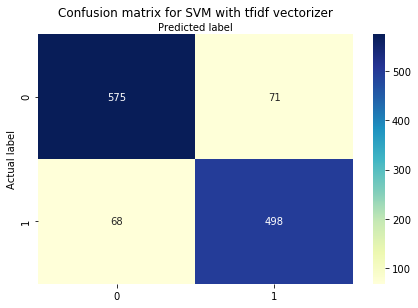

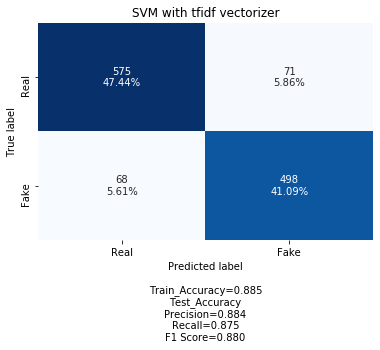

In [67]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
model_svm = SVM.fit(x_train, y_train)
predicted_svm_test = model_svm.predict(x_test)
predicted_svm_train = model_svm.predict(x_train)
con_matrix_svm = metrics.confusion_matrix(y_test, predicted_svm_test)
report_svm = metrics.classification_report(y_test, predicted_svm_test)
accuracy_test = metrics.accuracy_score(y_test, predicted_svm_test)
acuracy_train = metrics.accuracy_score(y_train, predicted_svm_train)
print(con_matrix_svm)
print(report_lr)
print("Test: ",accuracy_test)
print("Train: ",accuracy_train)
make_confusion_matrix(con_matrix_svm, accuracy_train, accuracy_test, categories=["Real", "Fake"], cbar=False, title="SVM with tfidf vectorizer")

In [29]:
X = data_set.text
Y = data_set.label

In [30]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, random_state=42, stratify=Y)

In [31]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', linear_model.LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1), (2,2), (1,3)], 'lr__C': [0.01, 1]}

gs = model_selection.GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(x_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(x_train, y_train))
print("Test score", gs.score(x_test, y_test))

gs.best_params_

Best score: 0.9062706270627063
Train score 0.9914191419141914
Test score 0.9181518151815181


{'cvec__ngram_range': (1, 3), 'lr__C': 0.01}

In [32]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1), (2,2), (1,3)], 'nb__alpha': [.36, .6]}

gs = model_selection.GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(x_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(x_train, y_train))
print("Test score", gs.score(x_test, y_test))

gs.best_params_

Best score: 0.8882288228822883
Train score 0.9997799779977998
Test score 0.9042904290429042


{'cvec__ngram_range': (1, 3), 'nb__alpha': 0.36}

In [33]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', linear_model.LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df':[.75, .98, 1.0],'tvect__min_df': [2, 3, 5], 'tvect__ngram_range': [(1,1), (1,2), (1,3)], 'lr__C': [0.01, 1]}

gs = model_selection.GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(x_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(x_train, y_train))
print("Test score", gs.score(x_test, y_test))

gs.best_params_

Best score: 0.9038503850385039
Train score 0.9623762376237623
Test score 0.9056105610561056


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 2,
 'tvect__ngram_range': (1, 3)}

In [34]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df':[.75, .98, 1.0],'tvect__min_df': [2, 3, 5], 'tvect__ngram_range': [(1,1), (1,2), (1,3)],  'nb__alpha': [.36, .6]}

gs = model_selection.GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(x_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(x_train, y_train))
print("Test score", gs.score(x_test, y_test))

gs.best_params_

Best score: 0.9062706270627062
Train score 0.9608360836083608
Test score 0.9042904290429042


{'nb__alpha': 0.36,
 'tvect__max_df': 0.75,
 'tvect__min_df': 5,
 'tvect__ngram_range': (1, 3)}